In [2]:
import sys; sys.path.append('../../wwa/'); from wwa import *

# broader region for plotting
xn, xx, yn, yx = [-18,52,0,35]

# region for West Africa time series analysis
Xn,Xx,Yn,Yx = [-10,20,10,17]
box_str = "_".join([str(i) for i in [Xn,Xx,Yn,Yx]])

# shapefile
sf = gpd.read_file("sf_malibf")

mapproj = cartopy.crs.PlateCarree()

bamako = get_latlon("Bamako, Mali")

fpath = "../../00_WWA_project_folder/ephemeral/00_Sahel-heat/"

# Sahel heatwave

- ERA5 tmax & tmin downloaded - extended version not yet available - also unclear whether we can trust - but we can talk about trends based on the data that is available
- MSWX tmax & tmin already include the event
- CMIP6 tmax & tmin currently downloading from Synda
- CMIP6 tx1x downloaded from Copernicus
- check seasonal cycle: do we need to split the region out at all?  
&nbsp;
- fit gridded model across Sahel region: local return periods as well as regional (although can we rely on ERA5 analysis for this?)

---
# Data pre-processing

## ERA5

In [ ]:
# Download ERA5 data from climate explorer
! cd /rds/general/user/cb2714/home/00_WWA_project_folder/ephemeral/00_Sahel-heat; wget https://climexp.knmi.nl/data/era5_tmax_daily_af_extended_-18-52E_0-35N_su.nc
! cd /rds/general/user/cb2714/home/00_WWA_project_folder/ephemeral/00_Sahel-heat; wget https://climexp.knmi.nl/data/era5_tmin_daily_af_extended_-18-52E_0-35N_su.nc

## MSWX

In [2]:
mswx_path = "../../00_WWA_project_folder/live/data/mswx/"
out_path = "../../00_WWA_project_folder/ephemeral/00_Sahel-heat/mswx/"

In [ ]:
varnm = "tmin"
for y in range(2024,1978,-1):
    
    new_fnm = out_path+varnm+"_mam_"+str(y)+".nc"
    
    if os.path.exists(new_fnm): continue
        
    fl = [fnm for fnm in sorted(glob.glob(mswx_path+varnm+"_*/"+str(y)+"*.nc")) if int(fnm[-6:-3]) >= 59 and int(fnm[-6:-3]) <= 152]
    da = wrap_lon(xr.open_mfdataset(fl)).air_temperature.sel(lon = slice(xn,xx), lat = slice(yn,yx), time = slice(str(y)+"-03", str(y)+"-05")).rename(varnm)
    da.to_netcdf(new_fnm)

## CMIP6 from Copernicus (monthly tx1x)

In [1]:
! cd /rds/general/user/cb2714/home/00_WWA_project_folder/ephemeral/00_Sahel-heat; wget https://download-0000-clone.copernicus-climate.eu/cache-compute-0000/cache/data3/adaptor.esgf_wps.retrieve-1712653060.156834-22281-9-9becd21d-53a0-45ce-b2f5-de4b043b7920.zip
! cd /rds/general/user/cb2714/home/00_WWA_project_folder/ephemeral/00_Sahel-heat; wget https://download-0006-clone.copernicus-climate.eu/cache-compute-0006/cache/data1/adaptor.esgf_wps.retrieve-1712654454.3825753-14305-12-37345cc8-d2fa-487d-bc7c-e44d557242ac.zip

/bin/bash: which: line 1: syntax error: unexpected end of file
/bin/bash: error importing function definition for `which'
/bin/bash: module: line 1: syntax error: unexpected end of file
/bin/bash: error importing function definition for `module'
/bin/bash: scl: line 1: syntax error: unexpected end of file
/bin/bash: error importing function definition for `scl'
/bin/bash: ml: line 1: syntax error: unexpected end of file
/bin/bash: error importing function definition for `ml'
--2024-04-09 10:20:26--  https://download-0000-clone.copernicus-climate.eu/cache-compute-0000/cache/data3/adaptor.esgf_wps.retrieve-1712653060.156834-22281-9-9becd21d-53a0-45ce-b2f5-de4b043b7920.zip
Resolving download-0000-clone.copernicus-climate.eu (download-0000-clone.copernicus-climate.eu)... 2a0c:5bc0:4c:ff::889c:9821, 136.156.152.33
Connecting to download-0000-clone.copernicus-climate.eu (download-0000-clone.copernicus-climate.eu)|2a0c:5bc0:4c:ff::889c:9821|:443... connected.
HTTP request sent, awaiting respo

# Create shapefile

In [2]:
sf_africa = gpd.read_file("sf_africa/")
sf_malibf = sf_africa.loc[[4,30]].dissolve().explode().clip([-20,0,10,16])

sf_malibf.to_file("sf_malibf")

---
# Physical geography

## Elevation

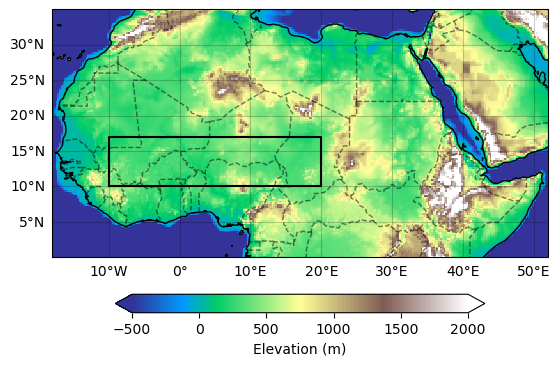

In [8]:
elev = wrap_lon(xr.open_dataset("../../00_WWA_project_folder/live/data/elev.0.25-deg.nc", decode_times = False)).squeeze(drop = True).data

elev.sel(lon = slice(xn,xx), lat = slice(yn,yx)).plot(cmap = "terrain", vmax = 2000, vmin = -500, subplot_kws = {"projection" : mapproj}, 
                                                      cbar_kwargs = {"location" : "bottom", "fraction" : 0.05, "pad" : 0.1, "label" : "Elevation (m)"})
ax = plt.gca()
ax.coastlines()
ax.add_feature(cartopy.feature.BORDERS, color = "k", alpha = 0.5, ls = "--")
ax.gridlines(color = "k", alpha = 0.2, draw_labels = ["left", "bottom"])
ax.plot([Xn,Xn,Xx,Xx,Xn], [Yn,Yx,Yx,Yn,Yn], color = "k", lw = 1.5)

plt.savefig("fig/elevation.png")

## Koppen-Geiger climatology

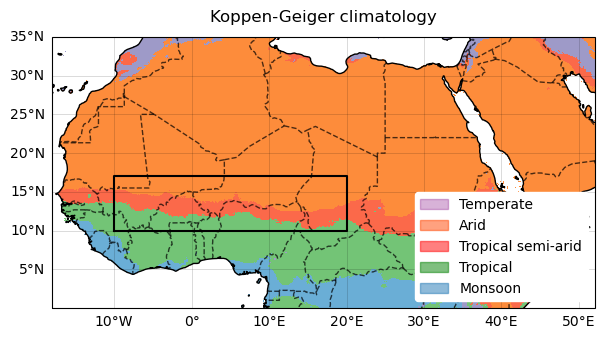

In [9]:
kg = xr.open_dataset("../../00_WWA_project_folder/live/data/koppen-geiger/kg_classifications.nc").kg_cat.sel(lon = slice(xn,xx), lat = slice(yn,yx))

kg_grouped = xr.apply_ufunc(np.digitize, kg, kwargs={'bins': [0.5,2.5,3.5,5.5,6.5,30]})

fig, ax = plt.subplots(ncols = 1, figsize = (7,5), dpi = 100, subplot_kw = {"projection" : mapproj})

kg_grouped.where(kg_grouped == 1).plot(ax = ax, cmap = "Blues", add_colorbar = False)      # tropical
kg_grouped.where(kg_grouped == 2).plot(ax = ax, cmap = "Greens", add_colorbar = False)   # arid
kg_grouped.where(kg_grouped == 3).plot(ax = ax, cmap = "Oranges", add_colorbar = False)    # temperate
kg_grouped.where(kg_grouped == 4).plot(ax = ax, cmap = "Reds", add_colorbar = False)     # cold
kg_grouped.where(kg_grouped == 5).plot(ax = ax, cmap = "Purples", add_colorbar = False)   # polar

ax.gridlines(crs=cartopy.crs.PlateCarree(), linewidth=0.5, color='black', draw_labels=["bottom", "left"], alpha=0.2)
ax.coastlines()
ax.add_feature(cartopy.feature.BORDERS, lw = 1, alpha = 0.7, ls = "--")

# add box around area of interest
ax.plot([Xn,Xn,Xx,Xx,Xn], [Yn,Yx,Yx,Yn,Yn], color = "k", lw = 1.5)

plt.legend(handles = [matplotlib.patches.Patch(color = "purple", label = "Temperate", alpha = 0.3),
                      matplotlib.patches.Patch(color = "orangered", label = "Arid", alpha = 0.5),
                      matplotlib.patches.Patch(color = "red", label = "Tropical semi-arid", alpha = 0.5), 
                      matplotlib.patches.Patch(color = "green", label = "Tropical", alpha = 0.5), 
                      matplotlib.patches.Patch(color = "tab:blue", label = "Monsoon", alpha = 0.5)
                      ], 
           facecolor = "w", framealpha = 1, edgecolor = "w", loc = "lower right")

plt.title("Koppen-Geiger climatology")
plt.savefig("fig/koppen-geiger climatology.png")

# Seasonal cycle per lat/lon

In [5]:
# seasonal cycle at each latitude - use daily data for this
tmax = xr.open_dataset("../../00_WWA_project_folder/ephemeral/00_Sahel-heat/era5_tmax_daily_af_extended_-18-52E_0-35N_su.nc").tmax
tmin = xr.open_dataset("../../00_WWA_project_folder/ephemeral/00_Sahel-heat/era5_tmin_daily_af_extended_-18-52E_0-35N_su.nc").tmin

In [6]:
sc_by_lat_tmax = tmax.groupby_bins(group = "lat", bins = range(yn,yx+1)).mean().mean("lon").groupby("time.dayofyear").mean()
sc_by_lat_tmin = tmin.groupby_bins(group = "lat", bins = range(yn,yx+1)).mean().mean("lon").groupby("time.dayofyear").mean()

In [15]:
# define axis labels for DOY plotting
days = pd.date_range(start = "2020-01-01", end = "2020-12-31")
labelticks = [i+1 for i in range(366) if (days[i].day) == 15]
labels = [days[i].strftime("%b") for i in range(366) if (days[i].day) == 15]

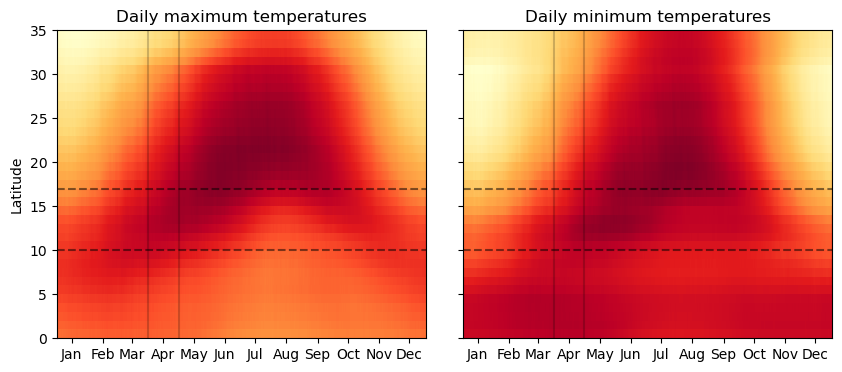

In [21]:
fig, axs = plt.subplots(ncols = 2, figsize = (10,4), dpi = 100, sharex = True, sharey = True)
plt.subplots_adjust(wspace = 0.1)

for i in range(2):
    ax = axs[i]
    sc = [sc_by_lat_tmax, sc_by_lat_tmin][i]
    ttl = ["maximum", "minimum"][i]
    
    sc.transpose().plot(ax = ax, cmap = "YlOrRd", add_colorbar = False)
    ax.set_xlabel("")
    ax.set_ylabel("")
    ax.set_title("Daily "+ttl+" temperatures")

    [ax.axhline(x, color = "k", alpha = 0.5, ls = "--") for x in [Yn,Yx]]
    [ax.axvline(x, color = "k", alpha = 0.2) for x in [91,121]]
    
    ax.set_xticks(labelticks)
    ax.set_xticklabels(labels)
    
axs[0].set_ylabel("Latitude")
    
plt.savefig("fig/seasonal-cycle-by-latitude_era5.png")

# 2024 anomalies

In [22]:
sites = pd.DataFrame.from_dict({k : get_latlon(k) for k in ["Bamako, Mali", "Timbuktu, Mali"]}).transpose()

varnm = "tmin"

temp_range = {"tmax" : {"vmin" : 0, "vmax" : 45}, "tmin" : {"vmin" : 0, "vmax" : 30}}
anom_range = {"tmax" : {"vmin" : -10, "vmax" : 10}, "tmin" : {"vmin" : -10, "vmax" : 10}}

In [9]:
# load tmax climatology
fl = [fnm for fnm in sorted(glob.glob(fpath+"mswx/"+varnm+"_mam_*.nc")) if int(fnm[-7:-3]) >= 1990 and int(fnm[-7:-3]) <= 2020][1:]
clim_apr = xr.open_mfdataset(fl)[varnm].groupby("time.month")[4].mean("time")

# load 2024 tmax
da = xr.open_dataset("../../00_WWA_project_folder/ephemeral/00_Sahel-heat/mswx/"+varnm+"_mam_2024.nc")[varnm]
rm = regionmask.defined_regions.natural_earth_v5_0_0.countries_110.mask_3D(da.lon, da.lat)
da = da.where(rm.sum("region") == 1)

# 2024 anomaly wrt April climatology
anom_apr = da - clim_apr

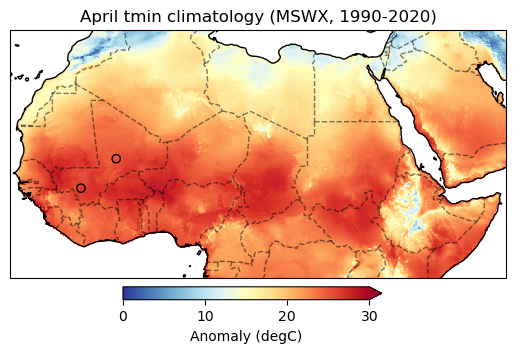

In [10]:
clim_apr.where(rm.sum("region") == 1).plot(**temp_range[varnm], cmap =  "RdYlBu_r", subplot_kws = {"projection" : mapproj},
                                                       cbar_kwargs = {"location" : "bottom", "fraction" : 0.035, "pad" : 0.025, "label" : "Anomaly (degC)"})

for ax in plt.gcf().axes[:1]:
    ax.coastlines()
    ax.add_feature(cartopy.feature.BORDERS, color = "k", alpha = 0.5, ls = "--")
    ax.scatter(sites.lon, sites.lat, marker = "o", edgecolors = "k", facecolors = "none")
    ax.plot([Xn,Xn,Xx,Xx,Xn], [Yn,Yx,Yx,Yn,Yn], color = "k", lw = 1.5)
    
ax.set_title("April "+varnm + " climatology (MSWX, 1990-2020)")
plt.savefig("fig/April-climatology-"+varnm+".png")

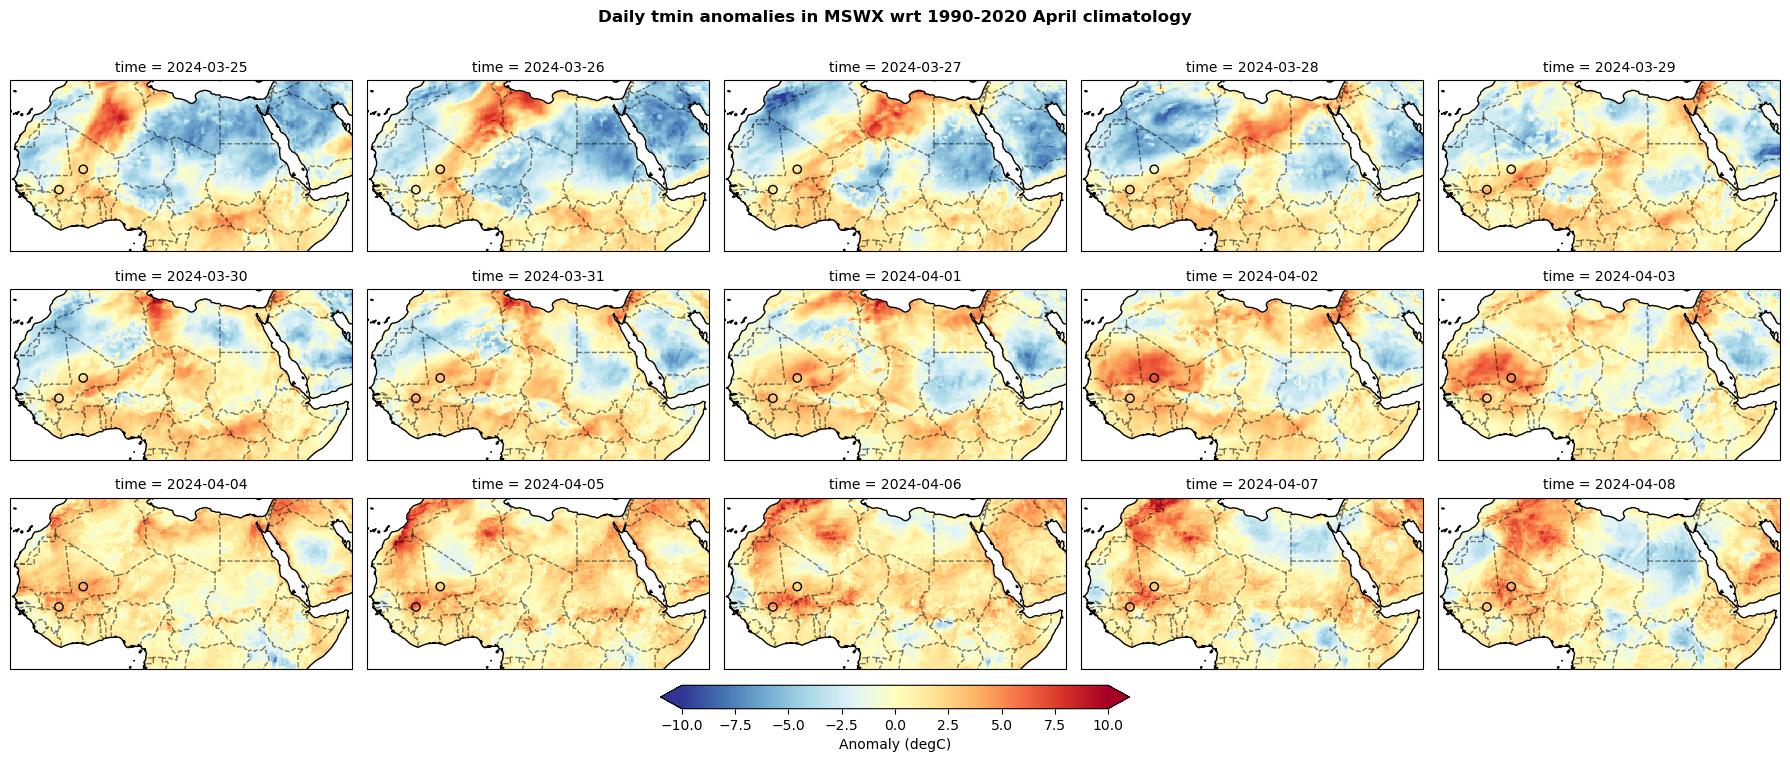

In [11]:
anom_apr.isel(time = slice(-15, None)).plot(col = "time", col_wrap = 5, figsize = (18,7), **anom_range[varnm], cmap =  "RdYlBu_r", subplot_kws = {"projection" : mapproj},
                                                      cbar_kwargs = {"location" : "bottom", "fraction" : 0.035, "pad" : 0.025, "label" : "Anomaly (degC)"})

for ax in plt.gcf().axes[:15]:
    ax.coastlines()
    ax.add_feature(cartopy.feature.BORDERS, color = "k", alpha = 0.5, ls = "--")
    ax.scatter(sites.lon, sites.lat, marker = "o", edgecolors = "k", facecolors = "none")
    ax.plot([Xn,Xn,Xx,Xx,Xn], [Yn,Yx,Yx,Yn,Yn], color = "k", lw = 1.5)

plt.suptitle("Daily "+varnm+" anomalies in MSWX wrt 1990-2020 April climatology", fontweight = "bold", y = 1.02)
    
plt.savefig("fig/daily-"+varnm+"-anomalies.png")

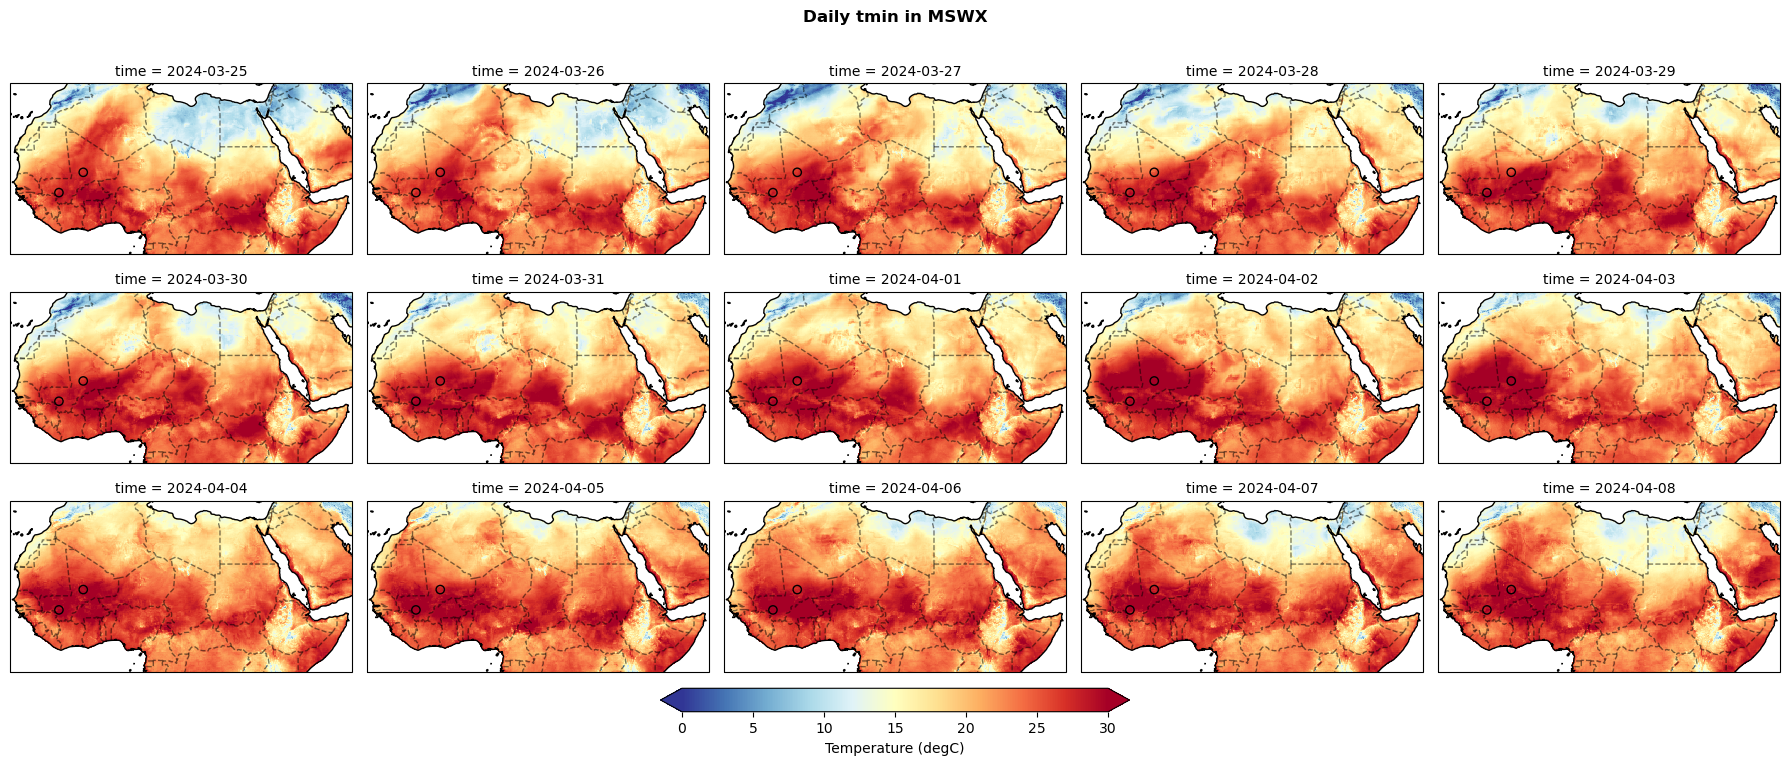

In [12]:
da.isel(time = slice(-15, None)).plot(col = "time", col_wrap = 5, cmap = "RdYlBu_r", **temp_range[varnm], figsize = (18,7), subplot_kws = {"projection" : mapproj},
                                             cbar_kwargs = {"location" : "bottom", "fraction" : 0.035, "pad" : 0.025, "label" : "Temperature (degC)"})

for ax in plt.gcf().axes[:15]:
    ax.coastlines()
    ax.add_feature(cartopy.feature.BORDERS, color = "k", alpha = 0.5, ls = "--")
    ax.scatter(sites.lon, sites.lat, marker = "o", edgecolors = "k", facecolors = "none")
    ax.plot([Xn,Xn,Xx,Xx,Xn], [Yn,Yx,Yx,Yn,Yn], color = "k", lw = 1.5)

plt.suptitle("Daily "+varnm+" in MSWX", fontweight = "bold", y = 1.025)

plt.savefig("fig/daily-"+varnm+".png")

# Maps of n-day accumulations

In [42]:
varnm = "tmin"
da = xr.open_dataset("../../00_WWA_project_folder/ephemeral/00_Sahel-heat/mswx/"+varnm+"_mam_2024.nc")[varnm]
rm = regionmask.defined_regions.natural_earth_v5_0_0.countries_110.mask_3D(da.lon, da.lat)
da = da.where(rm.sum("region") == 1)

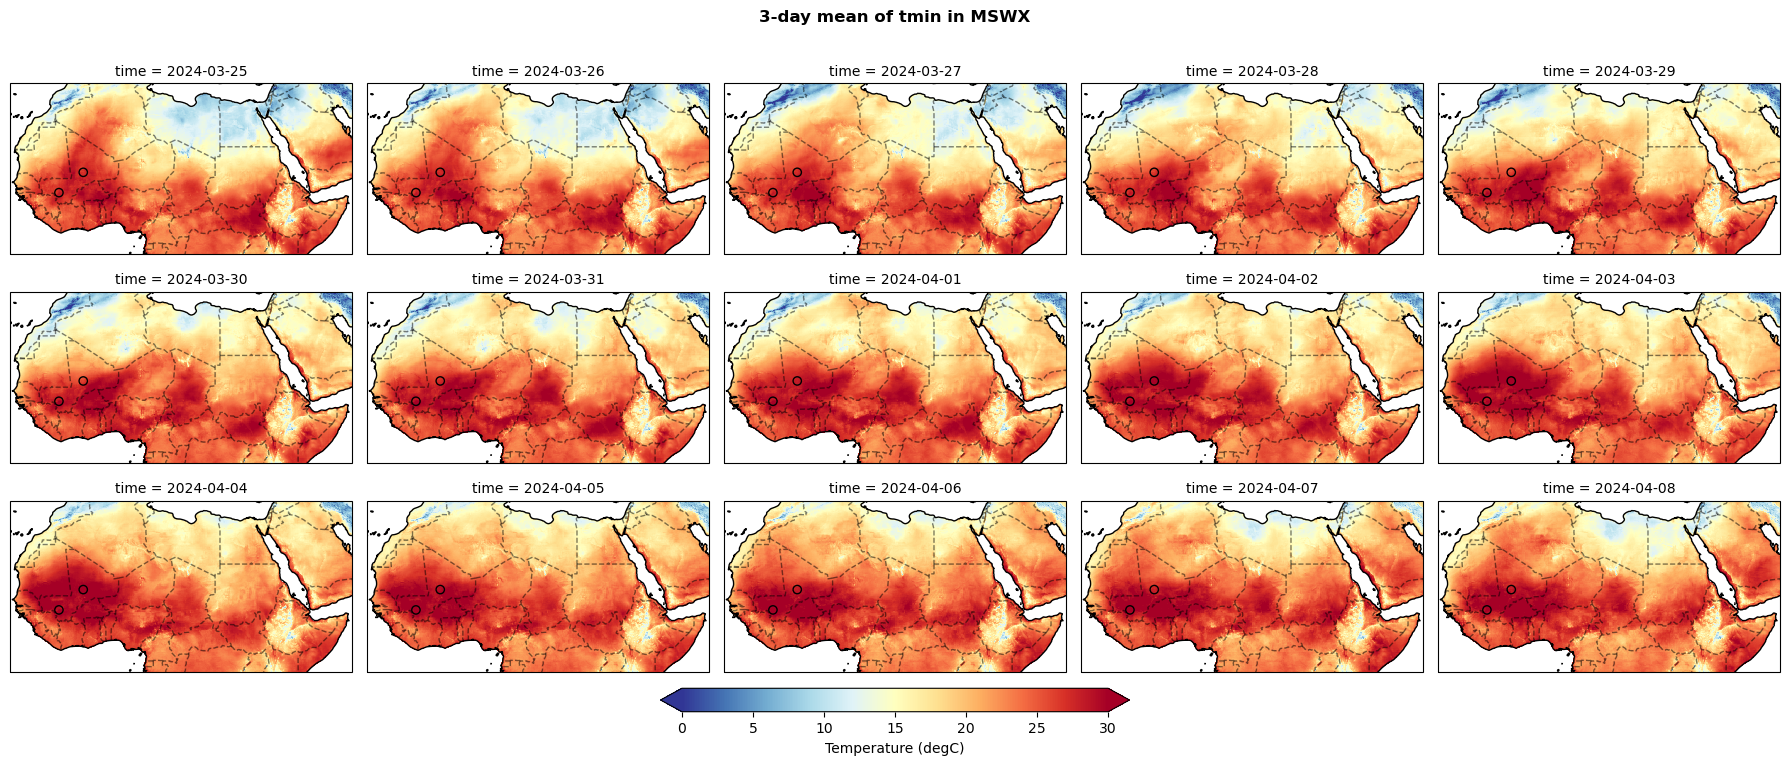

In [44]:
ndays = 3

da.rolling(time = ndays).mean().isel(time = slice(-15, None)).plot(col = "time", col_wrap = 5, cmap = "RdYlBu_r", **temp_range[varnm], figsize = (18,7), subplot_kws = {"projection" : mapproj},
                                             cbar_kwargs = {"location" : "bottom", "fraction" : 0.035, "pad" : 0.025, "label" : "Temperature (degC)"})

for ax in plt.gcf().axes[:15]:
    ax.coastlines()
    ax.add_feature(cartopy.feature.BORDERS, color = "k", alpha = 0.5, ls = "--")
    ax.scatter(sites.lon, sites.lat, marker = "o", edgecolors = "k", facecolors = "none")
    
plt.suptitle(str(ndays)+"-day mean of "+varnm+" in MSWX", fontweight = "bold", y = 1.025)

plt.savefig("fig/"+str(ndays)+"-day-"+varnm+"_mswx.png")

# Mali-Burkina Faso time series

In [50]:
# map to select country regions ( chad 15; niger 55; mauritania 53; burkina faso 65; mali 52)
# rm.plot(col = "region", col_wrap = 7, subplot_kws = {"projection" : mapproj, "extent" : [xn,xx,yn,yx]})
# for ax in plt.gcf().axes[:-1]:
#     ax.add_feature(cartopy.feature.BORDERS, color = "k", alpha = 0.6, ls = "--")

In [13]:
# MSWX
varnm = "tmax"

fl = sorted(glob.glob(fpath+"mswx/"+varnm+"_*.nc"))
da = xr.open_mfdataset(fl)[varnm]
rm = regionmask.defined_regions.natural_earth_v5_0_0.countries_110.mask_3D(da.lon, da.lat)

malibf = da.where(rm.sel(region = [52,65], lat = slice(None, 16)).sum("region") == 1).mean(["lat", "lon"])
malibf.to_netcdf("data/"+varnm+"_mswx_mali-burkinafaso.nc")

In [32]:
# ERA5
for varnm in ["tmax", "tmin"]:
    
    da = wrap_lon(xr.open_dataset(fpath+"era5_"+varnm+"_daily_af_extended_-18-52E_0-35N_su.nc"))[varnm]
    
    rm = regionmask.defined_regions.natural_earth_v5_0_0.countries_110.mask_3D(da.lon, da.lat).sel(region = [52,65], lat = slice(None, 16)).sum("region")
    ts = da.where(rm == 1).mean(["lat", "lon"])
    ts.to_netcdf("data/"+varnm+"_era5_mali-burkinafaso.nc")

In [14]:
# CPC
for varnm in ["tmax", "tmin"]:
    
    da = wrap_lon(xr.open_mfdataset("../../00_WWA_project_folder/live/data/cpc/"+varnm+"*.nc"))[varnm]
    
    rm = regionmask.defined_regions.natural_earth_v5_0_0.countries_110.mask_3D(da.lon, da.lat).sel(region = [52,65], lat = slice(None, 16)).sum("region")
    ts = da.where(rm == 1).mean(["lat", "lon"])
    ts.to_netcdf("data/"+varnm+"_cpc_mali-burkinafaso.nc")

## Compare timescales

In [21]:
tmax = xr.open_dataset("tmax_mswx_mali-burkinafaso.nc").tmax
tmin = xr.open_dataset("tmin_mswx_mali-burkinafaso.nc").tmin

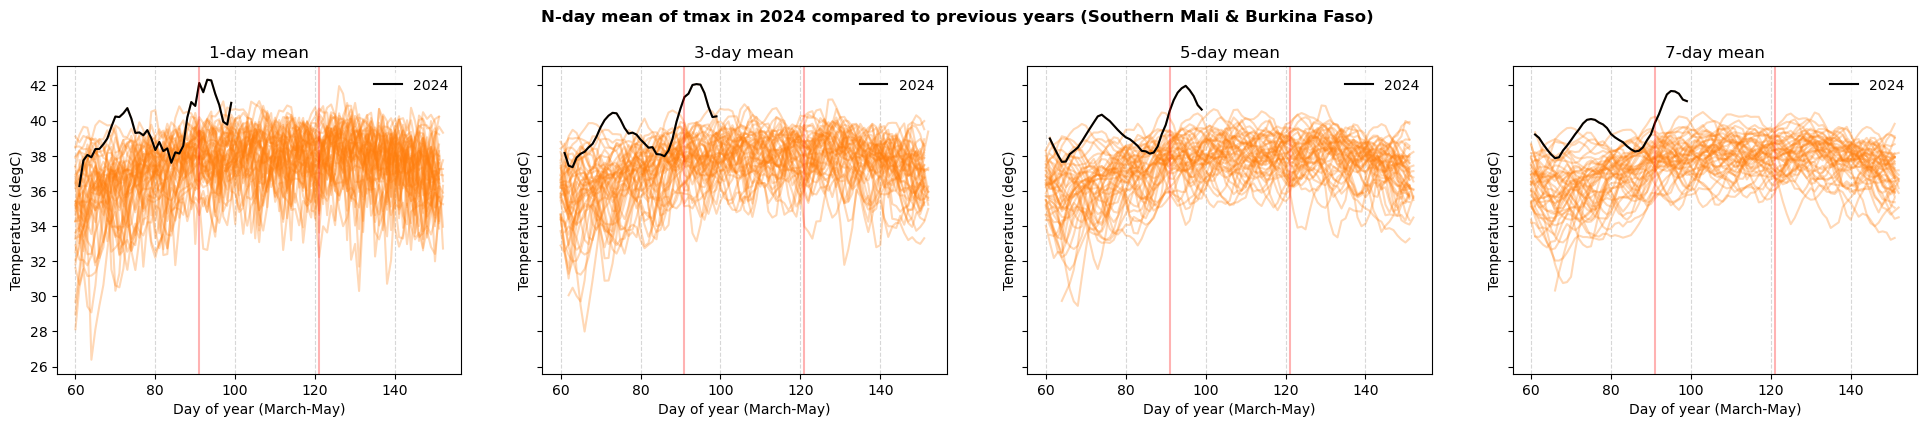

In [22]:
fig, axs = plt.subplots(ncols = 4, nrows = 1, figsize = (6*4,4*1), dpi = 100, sharey = True)

for i in range(4):
    
    ndays = [1,3,5,7,9,15][i]
    ax = plt.gcf().axes[i]
    ts = tmax.rolling(time = ndays, center = False).mean()

    # plot each year individually so that the overlapping transparencies interact
    for y in set(ts.time.dt.year.values): 
        ax.plot(ts.sel(time = str(y)).time.dt.dayofyear, ts.sel(time = str(y)), color = "tab:orange", alpha = 0.3)
    ax.plot(ts.sel(time = "2024").time.dt.dayofyear, ts.sel(time = "2024"), color = "k", label = "2024")
    ax.legend(edgecolor = "w")
    ax.set_xlabel("Day of year (March-May)")
    ax.set_ylabel("Temperature (degC)")
    ax.grid(axis = "x", alpha = 0.5, ls = "--")
    [ax.axvline(x, color = "red", alpha = 0.3) for x in [91,121]]
    
    ax.set_title(str(ndays)+"-day mean")
        
    fig.suptitle("N-day mean of tmax in 2024 compared to previous years (Southern Mali & Burkina Faso)", fontweight = "bold", y = 1.02)
    plt.savefig("fig/n-day-mean-of-tmax_mali-bf.png")

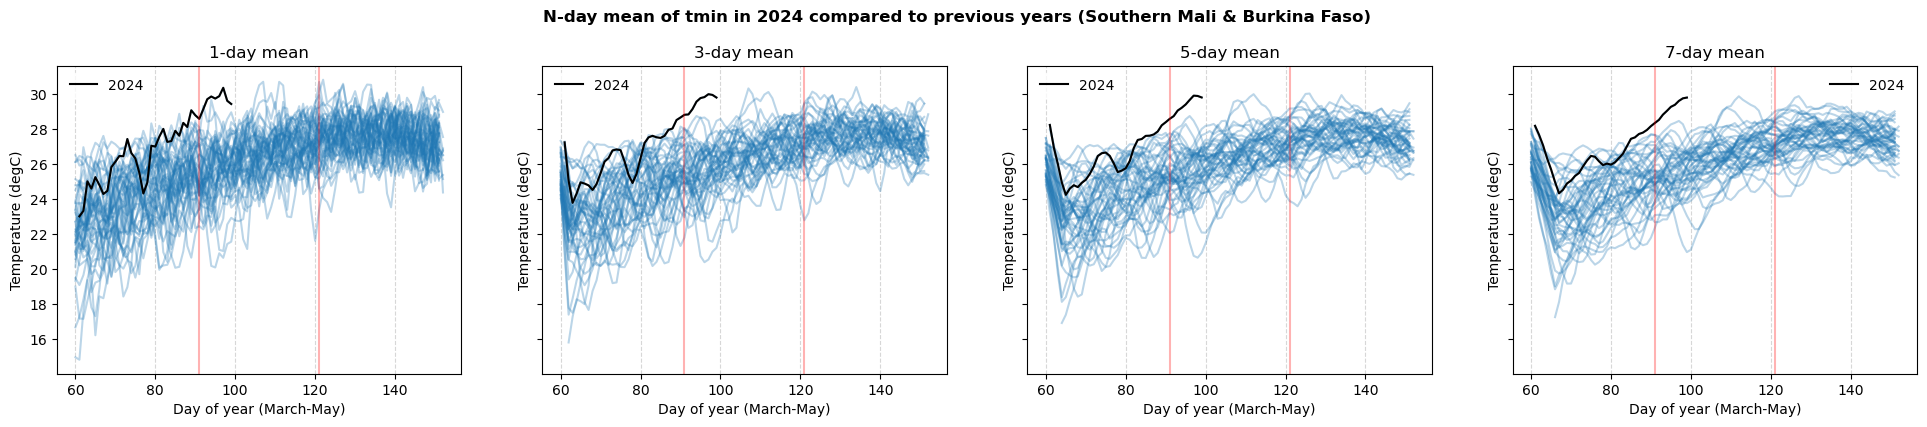

In [23]:
fig, axs = plt.subplots(ncols = 4, nrows = 1, figsize = (6*4,4*1), dpi = 100, sharey = True)

for i in range(4):
    
    ndays = [1,3,5,7,9,15][i]
    ax = plt.gcf().axes[i]
    ts = tmin.rolling(time = ndays, center = False).mean()

    # plot each year individually so that the overlapping transparencies interact
    for y in set(ts.time.dt.year.values): 
        ax.plot(ts.sel(time = str(y)).time.dt.dayofyear, ts.sel(time = str(y)), color = "tab:blue", alpha = 0.3)
    ax.plot(ts.sel(time = "2024").time.dt.dayofyear, ts.sel(time = "2024"), color = "k", label = "2024")
    ax.legend(edgecolor = "w")
    ax.set_xlabel("Day of year (March-May)")
    ax.set_ylabel("Temperature (degC)")
    ax.grid(axis = "x", alpha = 0.5, ls = "--")
    [ax.axvline(x, color = "red", alpha = 0.3) for x in [91,121]]

    ax.set_title(str(ndays)+"-day mean")
        
    fig.suptitle("N-day mean of tmin in 2024 compared to previous years (Southern Mali & Burkina Faso)", fontweight = "bold", y = 1.02)
    plt.savefig("fig/n-day-mean-of-tmin_mali-bf.png")

## Time series for climate explorer

In [42]:
# MAM maxima - tmax only
for ds in ["mswx", "cpc", "era5"]:
    for varnm in ["tmax"]:
        for ndays in [1,3,5]:

            ts = xr.open_dataset("data/"+varnm+"_"+ds+"_mali-burkinafaso.nc")[varnm].rolling(time = ndays).mean().resample(time = "AS-JAN").max()
            ts = ts.assign_coords(time = ts.time.dt.year).rename(time = "year").to_dataframe()

            csv_fnm = "sahel-heat_"+varnm[0]+varnm[3]+str(ndays)+"x-mam_mali-bf_"+ds
            csv_fullpath = "ts/"+csv_fnm+".dat"

            if len(csv_fnm) > 61: print("! Filename too long: ", csv_fnm)

            # create extra header lines for upload to Climate Explorer 
            str1 = "# contact :: "+ds.upper()+" spring maxima of "+str(ndays)+"-day "+varnm+" - Sahel heat 2024, c.barnes22@imperial.ac.uk"
            str2 = "# "+varnm+" [degC] March-May maximum of "+str(ndays)+"-day "+varnm[1:]+"imum temperatures in southern Mali & Burkina Faso at "+csv_fnm+".dat"
            head = "# year "+varnm

            # make .dat file
            ! echo "$str1 " > $csv_fullpath
            ! echo "$str2" >> $csv_fullpath
            ! echo "$head" >> $csv_fullpath
            ts.to_csv(csv_fullpath, sep = " ", mode = "a", header = False)

            clear_output(wait = False)

In [41]:
# April maxima
for ds in ["mswx", "cpc", "era5"]:
    for varnm in ["tmax", "tmin"]:
        for ndays in [1,3,5]:

            ts = xr.open_dataset("data/"+varnm+"_"+ds+"_mali-burkinafaso.nc")[varnm].rolling(time = ndays).mean().groupby("time.month")[4].resample(time = "AS-JAN").max()
            ts = ts.assign_coords(time = ts.time.dt.year).rename(time = "year").to_dataframe()

            csv_fnm = "sahel-heat_"+varnm[0]+varnm[3]+str(ndays)+"x-april_mali-bf_"+ds
            csv_fullpath = "ts/"+csv_fnm+".dat"

            if len(csv_fnm) > 61: print("! Filename too long: ", csv_fnm)

            # create extra header lines for upload to Climate Explorer 
            str1 = "# contact :: "+ds.upper()+" April maxima of "+str(ndays)+"-day "+varnm+" - Sahel heat 2024, c.barnes22@imperial.ac.uk"
            str2 = "# "+varnm+" [degC] April maximum of "+str(ndays)+"-day "+varnm[1:]+"imum temperatures in southern Mali & Burkina Faso at "+csv_fnm+".dat"
            head = "# year "+varnm

            # make .dat file
            ! echo "$str1 " > $csv_fullpath
            ! echo "$str2" >> $csv_fullpath
            ! echo "$head" >> $csv_fullpath
            ts.to_csv(csv_fullpath, sep = " ", mode = "a", header = False)

            clear_output(wait = False)

# W Africa inland time series

In [39]:
# MSWX
for varnm in ["tmax","tmin"]:

    fl = sorted(glob.glob(fpath+"mswx/"+varnm+"_*.nc"))
    da = xr.open_mfdataset(fl)[varnm]

    da.sel(lon = slice(Xn,Xx), lat = slice(Yn,Yx)).mean(["lon", "lat"]).to_netcdf(varnm+"_mswx_"+box_str+".nc")

In [31]:
# ERA5
for varnm in ["tmax", "tmin"]:
    
    da = wrap_lon(xr.open_dataset(fpath+"era5_"+varnm+"_daily_af_extended_-18-52E_0-35N_su.nc"))[varnm]
    ts = da.sel(lon = slice(Xn,Xx), lat = slice(Yn,Yx)).mean(["lon", "lat"])
    ts.to_netcdf("data/"+varnm+"_era5_"+box_str+".nc")

In [16]:
# CPC
for varnm in ["tmax", "tmin"]:
    
    da = wrap_lon(xr.open_mfdataset("../../00_WWA_project_folder/live/data/cpc/"+varnm+"*.nc"))[varnm]
    ts = da.sel(lon = slice(Xn,Xx), lat = slice(Yn,Yx)).mean(["lon", "lat"])
    ts.to_netcdf("data/"+varnm+"_cpc_"+box_str+".nc")

## Compare timescales

In [39]:
tmax = xr.open_dataset("tmax_mswx_"+box_str+".nc").tmax
tmin = xr.open_dataset("tmin_mswx_"+box_str+".nc").tmin

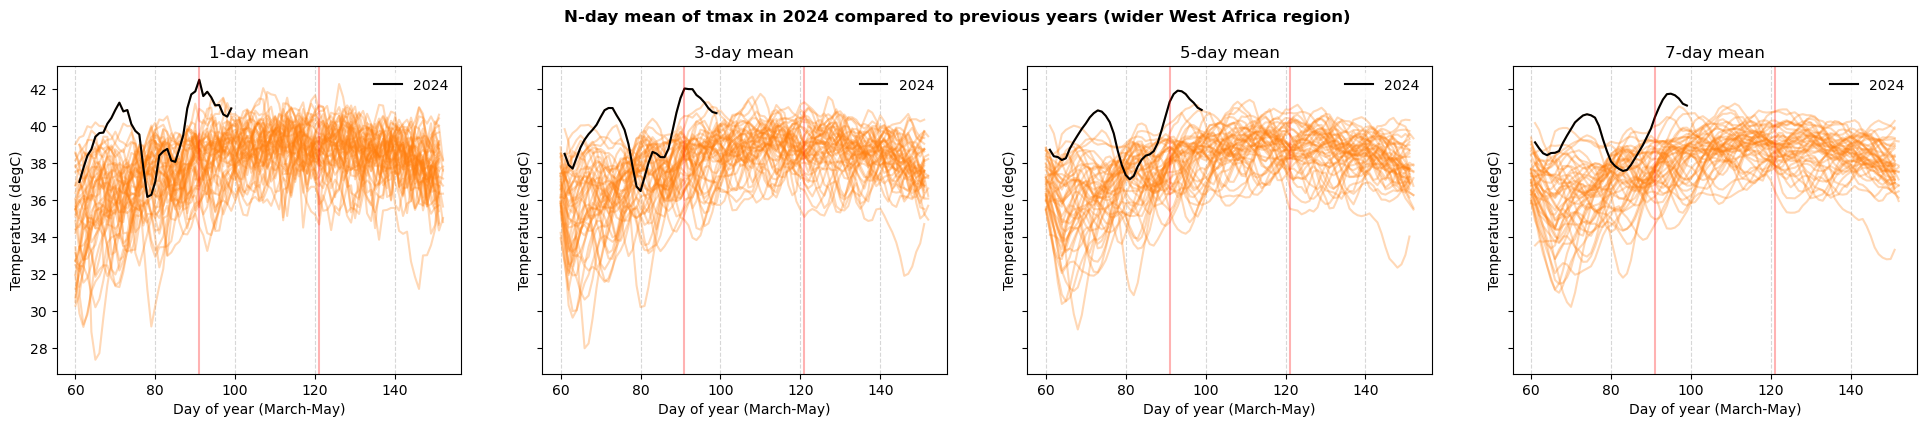

In [19]:
fig, axs = plt.subplots(ncols = 4, nrows = 1, figsize = (6*4,4*1), dpi = 100, sharey = True)

for i in range(4):
    
    ndays = [1,3,5,7,9,15][i]
    ax = plt.gcf().axes[i]
    ts = tmax.rolling(time = ndays, center = False).mean()

    # plot each year individually so that the overlapping transparencies interact
    for y in set(ts.time.dt.year.values): 
        ax.plot(ts.sel(time = str(y)).time.dt.dayofyear, ts.sel(time = str(y)), color = "tab:orange", alpha = 0.3)
    ax.plot(ts.sel(time = "2024").time.dt.dayofyear, ts.sel(time = "2024"), color = "k", label = "2024")
    ax.legend(edgecolor = "w")
    ax.set_xlabel("Day of year (March-May)")
    ax.set_ylabel("Temperature (degC)")
    ax.grid(axis = "x", alpha = 0.5, ls = "--")
    [ax.axvline(x, color = "red", alpha = 0.3) for x in [91,121]]
    
    ax.set_title(str(ndays)+"-day mean")
        
    fig.suptitle("N-day mean of tmax in 2024 compared to previous years (wider West Africa region)", fontweight = "bold", y = 1.02)
    plt.savefig("fig/n-day-mean-of-tmax_"+box_str+".png")

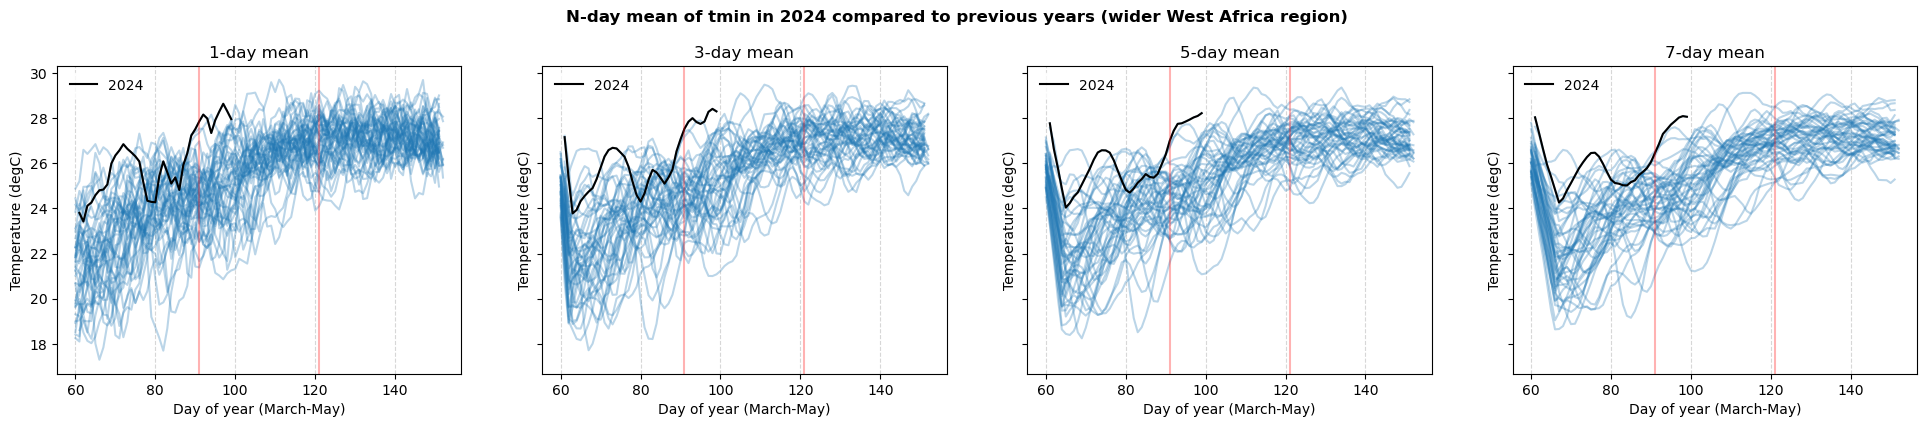

In [20]:
fig, axs = plt.subplots(ncols = 4, nrows = 1, figsize = (6*4,4*1), dpi = 100, sharey = True)

for i in range(4):
    
    ndays = [1,3,5,7,9,15][i]
    ax = plt.gcf().axes[i]
    ts = tmin.rolling(time = ndays, center = False).mean()

    # plot each year individually so that the overlapping transparencies interact
    for y in set(ts.time.dt.year.values): 
        ax.plot(ts.sel(time = str(y)).time.dt.dayofyear, ts.sel(time = str(y)), color = "tab:blue", alpha = 0.3)
    ax.plot(ts.sel(time = "2024").time.dt.dayofyear, ts.sel(time = "2024"), color = "k", label = "2024")
    ax.legend(edgecolor = "w")
    ax.set_xlabel("Day of year (March-May)")
    ax.set_ylabel("Temperature (degC)")
    ax.grid(axis = "x", alpha = 0.5, ls = "--")
    [ax.axvline(x, color = "red", alpha = 0.3) for x in [91,121]]

    ax.set_title(str(ndays)+"-day mean")
        
    fig.suptitle("N-day mean of tmin in 2024 compared to previous years (wider West Africa region)", fontweight = "bold", y = 1.02)
    plt.savefig("fig/n-day-mean-of-tmin_"+box_str+".png")

## Time series for climate explorer

In [39]:
# MAM maxima
for ds in ["mswx", "cpc", "era5"]:
    for varnm in ["tmax", "tmin"]:
        for ndays in [1,3,5]:

            ts = xr.open_dataset("data/"+varnm+"_"+ds+"_"+box_str+".nc")[varnm].rolling(time = ndays).mean().resample(time = "AS-JAN").max()
            ts = ts.assign_coords(time = ts.time.dt.year).rename(time = "year").to_dataframe()

            csv_fnm = "sahel-heat_"+varnm[0]+varnm[3]+str(ndays)+"x-mam_"+box_str+"_"+ds
            csv_fullpath = "ts/"+csv_fnm+".dat"

            if len(csv_fnm) > 61: print("! Filename too long: ", csv_fnm)

            # create extra header lines for upload to Climate Explorer 
            str1 = "# contact :: "+ds.upper()+" spring maxima of "+str(ndays)+"-day "+varnm+" - Sahel heat 2024, c.barnes22@imperial.ac.uk"
            str2 = "# "+varnm+" [degC] March-May maximum of "+str(ndays)+"-day "+varnm[1:]+"imum temperatures across West Africa region at "+csv_fnm+".dat"
            head = "# year "+varnm

            # make .dat file
            ! echo "$str1 " > $csv_fullpath
            ! echo "$str2" >> $csv_fullpath
            ! echo "$head" >> $csv_fullpath
            ts.to_csv(csv_fullpath, sep = " ", mode = "a", header = False)

            clear_output(wait = False)

In [40]:
# April maxima
for ds in ["mswx", "cpc", "era5"]:
    for varnm in ["tmax", "tmin"]:
        for ndays in [1,3,5]:

            ts = xr.open_dataset("data/"+varnm+"_"+ds+"_"+box_str+".nc")[varnm].rolling(time = ndays).mean().groupby("time.month")[4].resample(time = "AS-JAN").max()
            ts = ts.assign_coords(time = ts.time.dt.year).rename(time = "year").to_dataframe()

            csv_fnm = "sahel-heat_"+varnm[0]+varnm[3]+str(ndays)+"x-april_"+box_str+"_"+ds
            csv_fullpath = "ts/"+csv_fnm+".dat"

            if len(csv_fnm) > 61: print("! Filename too long: ", csv_fnm)

            # create extra header lines for upload to Climate Explorer 
            str1 = "# contact :: "+ds.upper()+" April maxima of "+str(ndays)+"-day "+varnm+" - Sahel heat 2024, c.barnes22@imperial.ac.uk"
            str2 = "# "+varnm+" [degC] April maximum of "+str(ndays)+"-day "+varnm[1:]+"imum temperatures across West Africa region at "+csv_fnm+".dat"
            head = "# year "+varnm

            # make .dat file
            ! echo "$str1 " > $csv_fullpath
            ! echo "$str2" >> $csv_fullpath
            ! echo "$head" >> $csv_fullpath
            ts.to_csv(csv_fullpath, sep = " ", mode = "a", header = False)

            clear_output(wait = False)

# Event maps

In [34]:
ndays = 5
varnm = "tmax"

da = xr.open_dataset("../../00_WWA_project_folder/ephemeral/00_Sahel-heat/mswx/"+varnm+"_mam_2024.nc")[varnm]

lsm = regionmask.defined_regions.natural_earth_v5_0_0.countries_110.mask_3D(da.lon, da.lat).sum("region")
da = da.where(lsm == 1)

vrange = {"tmax" : {"vmin" : 15, "vmax" : 45}, "tmin" : {"vmin" : 10, "vmax" : 33}}[varnm]

In [35]:
malibf_eventdate = da.where(regionmask.mask_3D_geopandas(sf, da.lon, da.lat).squeeze(drop = True)).mean(["lat", "lon"]).rolling(time = ndays).mean().idxmax()
waf_eventdate = da.sel(lon = slice(Xn,Xx), lat = slice(Yn,Yx)).mean(["lat", "lon"]).rolling(time = ndays).mean().idxmax()

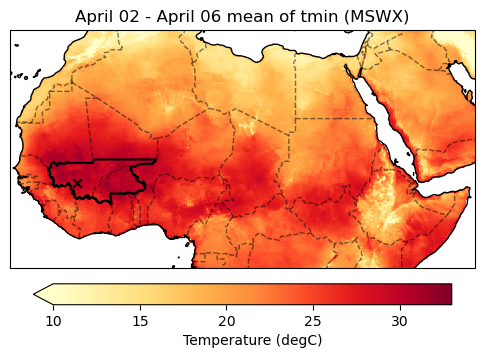

In [35]:
cbar_kwargs = {"location" : "bottom", "pad" : 0.05, "shrink" : 0.9, "label" : "Temperature (degC)"}
fig, ax = plt.subplots(figsize = (6,4), dpi = 100, subplot_kw = {"projection" : mapproj})

da.rolling(time = ndays).mean().sel(time = malibf_eventdate).plot(ax = ax, cmap = "YlOrRd", **vrange, cbar_kwargs = cbar_kwargs)

ax.coastlines()
ax.add_feature(cartopy.feature.BORDERS, color = "k", alpha = 0.5, ls = "--")
sf.boundary.plot(ax = ax, color = "k", lw = 1.5)

ax.scatter(bamako["lon"], bamako["lat"], marker = "x", color = "k")
ax.set_title((malibf_eventdate - np.timedelta64(4, "D")).dt.strftime("%B %d").values + " - " + malibf_eventdate.dt.strftime("%B %d").values+" mean of "+varnm+" (MSWX)")

plt.savefig("fig/event-map_"+varnm+"-"+str(ndays)+"day_mali-bf.png")

Text(0.5, 1.0, 'March 29 - April 02 mean of tmax (MSWX)')

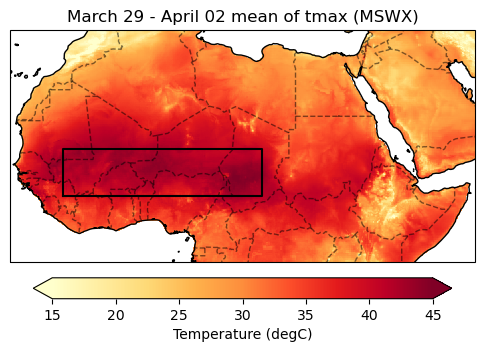

In [37]:
cbar_kwargs = {"location" : "bottom", "pad" : 0.05, "shrink" : 0.9, "label" : "Temperature (degC)"}
fig, ax = plt.subplots(figsize = (6,4), dpi = 100, subplot_kw = {"projection" : mapproj})

da.rolling(time = ndays).mean().sel(time = waf_eventdate).plot(ax = ax, cmap = "YlOrRd", **vrange, cbar_kwargs = cbar_kwargs)

ax.coastlines()
ax.add_feature(cartopy.feature.BORDERS, color = "k", alpha = 0.5, ls = "--")

ax.plot([Xn,Xn,Xx,Xx,Xn], [Yn,Yx,Yx,Yn,Yn], color = "k", lw = 1.5)

ax.set_title((waf_eventdate - np.timedelta64(4, "D")).dt.strftime("%B %d").values + " - " + waf_eventdate.dt.strftime("%B %d").values+" mean of "+varnm+" (MSWX)")

# plt.savefig("fig/event-map_"+varnm+"-"+str(ndays)+"day_box.png")